This is my first attempt at using SageMaker DeepAR. The example notebook given can be seen <a href = "https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb">here</a> and I am currently trying to plug in my data.

# Time series forecasting with DeepAR - Synthetic data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

In [3]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

We will use the sagemaker client library for easy interface with sagemaker and s3fs for uploading the training data to S3. (Use `pip` to install missing libraries)

In [8]:
!conda update -n base -c defaults conda -y

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3

  added / updated specs: 
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2r             |       h7b6447c_0         3.2 MB
    conda-4.6.8                |           py36_0         1.7 MB
    certifi-2019.3.9           |           py36_0         155 KB
    ------------------------------------------------------------
                                           Total:         5.0 MB

The following packages will be UPDATED:

    certifi: 2018.11.29-py36_0 --> 2019.3.9-py36_0  
    conda:   4.5.12-py36_0     --> 4.6.8-py36_0     
    openssl: 1.0.2p-h14c3975_0 --> 1.0.2r-h7b6447c_0


openssl-1.0.2r       | 3.2 MB    | ##################################### | 100% 
conda-4.6.8          | 1.7 MB    | ##################################### | 100% 
certifi-2019.3.9     | 155 KB

In [9]:
!conda install -y s3fs

Solving environment: done

## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - s3fs


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2018.11.~ --> pkgs/main::ca-certificates-2019.1.23-0
  certifi            conda-forge::certifi-2018.11.29-py36_~ --> pkgs/main::certifi-2019.3.9-py36_0
  openssl            conda-forge::openssl-1.0.2p-h14c3975_~ --> pkgs/main::openssl-1.0.2r-h7b6447c_0
  s3fs                                         0.1.5-py36_0 --> 0.2.0-py36_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [10]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [11]:
bucket = '#####'
prefix = 'sagemaker/Ferry-deepar-1'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Generating and uploading data

<a href = "https://stackoverflow.com/questions/48264656/load-s3-data-into-aws-sagemaker-notebook">Load S3 Data into AWS SageMaker Notebook</a>

In [14]:
role = get_execution_role()
data_key = 'Bainbridge_Departures_2013_Interpolated.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [33]:
df = pd.read_csv(data_location, parse_dates = ["timestamps"], index_col = "timestamps")
time_series = df["seconds_late"]

We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In our example we will use a longer `context_length` of `72`. Note that in addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

In [34]:
context_length = 72
prediction_length = 48

Often one is interested in tuning or evaluating the model by looking at error metrics on a hold-out set. For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

In this example, we will leave out the last section of each of the time series we just generated and use only the first part as training data. Here we will predict 48 data points, therefore we take out the trailing 48 points from each time series to define the training set. The test set contains the full range of each time series.

In [36]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(time_series, test_size = .33)

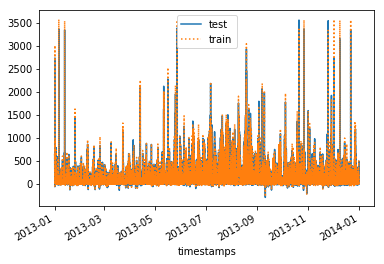

In [38]:
test.plot(label='test')
train.plot(label='train', ls=':')
plt.legend()
plt.show()

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [39]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [40]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    #for ts in time_series_training:
        fp.write(series_to_jsonline(train).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    #for ts in time_series:
        fp.write(series_to_jsonline(test).encode(encoding))
        fp.write('\n'.encode(encoding))

### Train a model

We can now define the estimator that will launch the training job.

In [41]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='Ferry-deepar-1',
    output_path="s3://" + s3_output_path
)

Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [49]:
freq = '5min'

In [43]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [44]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [45]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: Ferry-deepar-1-2019-03-27-17-21-33-127


2019-03-27 17:21:33 Starting - Starting the training job...
2019-03-27 17:21:34 Starting - Launching requested ML instances......
2019-03-27 17:22:44 Starting - Preparing the instances for training.........
2019-03-27 17:24:32 Downloading - Downloading input data
2019-03-27 17:24:32 Training - Training image download completed. Training in progress..
Arguments: train
[03/27/2019 17:24:34 INFO 140410741557056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[03

[03/27/2019 17:24:51 INFO 140410741557056] Epoch[3] Batch[10] avg_epoch_loss=7.013236
[03/27/2019 17:24:51 INFO 140410741557056] Epoch[3] Batch [10]#011Speed: 166.65 samples/sec#011loss=7.039560
[03/27/2019 17:24:51 INFO 140410741557056] processed a total of 323 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2646.707057952881, "sum": 2646.707057952881, "min": 2646.707057952881}}, "EndTime": 1553707491.145035, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1553707488.498269}

[03/27/2019 17:24:51 INFO 140410741557056] #throughput_metric: host=algo-1, train throughput=122.033284142 records/second
[03/27/2019 17:24:51 INFO 140410741557056] #progress_metric: host=algo-1, completed 20 % of epochs
[03/27/2019 17:24:51 INFO 140410741557056] loss did not improve
[03/27/2019 17:24:51 INFO 140410741557056] Epoch[4] Batch[0] avg_epoch_loss=7.021612
[03/27/2019 17:24:52 INFO 140410741557056] Epoch[4] Batch[5] avg_epoch_loss=6.9

[03/27/2019 17:25:10 INFO 140410741557056] Epoch[11] Batch[5] avg_epoch_loss=6.920469
[03/27/2019 17:25:10 INFO 140410741557056] Epoch[11] Batch [5]#011Speed: 179.17 samples/sec#011loss=6.920469
[03/27/2019 17:25:11 INFO 140410741557056] processed a total of 284 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2127.2120475769043, "sum": 2127.2120475769043, "min": 2127.2120475769043}}, "EndTime": 1553707511.320799, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1553707509.193535}

[03/27/2019 17:25:11 INFO 140410741557056] #throughput_metric: host=algo-1, train throughput=133.501363444 records/second
[03/27/2019 17:25:11 INFO 140410741557056] #progress_metric: host=algo-1, completed 60 % of epochs
[03/27/2019 17:25:11 INFO 140410741557056] best epoch loss so far
[03/27/2019 17:25:11 INFO 140410741557056] Saved checkpoint to "/opt/ml/model/state_61f6632e-2031-4b49-ba44-fbf57443f403-0000.params"
#metrics {"Metrics": {"st

[03/27/2019 17:25:30 INFO 140410741557056] Epoch[19] Batch[5] avg_epoch_loss=6.951453
[03/27/2019 17:25:30 INFO 140410741557056] Epoch[19] Batch [5]#011Speed: 170.75 samples/sec#011loss=6.951453
[03/27/2019 17:25:31 INFO 140410741557056] processed a total of 314 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2387.047052383423, "sum": 2387.047052383423, "min": 2387.047052383423}}, "EndTime": 1553707531.631165, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1553707529.243701}

[03/27/2019 17:25:31 INFO 140410741557056] #throughput_metric: host=algo-1, train throughput=131.53679038 records/second
[03/27/2019 17:25:31 INFO 140410741557056] #progress_metric: host=algo-1, completed 100 % of epochs
[03/27/2019 17:25:31 INFO 140410741557056] loss did not improve
[03/27/2019 17:25:31 INFO 140410741557056] Final loss: 6.90204347264 (occurred at epoch 17)
[03/27/2019 17:25:31 INFO 140410741557056] #quality_metric: host=algo-1,

### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [46]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    #instance_type='ml.m4.xlarge',
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: Ferry-deepar-1-2019-03-27-17-21-33-127
INFO:sagemaker:Creating endpoint-config with name Ferry-deepar-1-2019-03-27-17-21-33-127
INFO:sagemaker:Creating endpoint with name Ferry-deepar-1-2019-03-27-17-21-33-127


---------------------------------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [47]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [50]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [51]:
endpoint_name

'Ferry-deepar-1-2019-03-27-17-21-33-127'

### Make predictions and plot results

Now we can use the previously created `predictor` object. For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [54]:
train[:5]

timestamps
2013-11-20 21:35:00     51.200000
2013-06-14 06:45:00     26.222222
2013-07-30 18:15:00     45.750000
2013-05-21 18:55:00    163.750000
2013-02-04 02:55:00     -0.350000
Name: seconds_late, dtype: float64

In [53]:
list_of_df = predictor.predict(train[:5])
actual_data = test[:5]

AttributeError: 'float' object has no attribute 'index'

In [51]:
list_of_df[0].tail()

,0.1,0.5,0.9
2016-01-17 11:00:00,4.121742,4.406670,4.632332
2016-01-17 12:00:00,3.759808,3.985285,4.256010
2016-01-17 13:00:00,3.410925,3.662372,3.979893
2016-01-17 14:00:00,2.967909,3.291872,3.587539
2016-01-17 15:00:00,2.727642,2.997155,3.259640


In [50]:
actual_data[0].tail()

2016-01-17 11:00:00    4.703353
2016-01-17 12:00:00    4.162845
2016-01-17 13:00:00    4.269130
2016-01-17 14:00:00    3.238696
2016-01-17 15:00:00    3.254041
Freq: H, dtype: float64

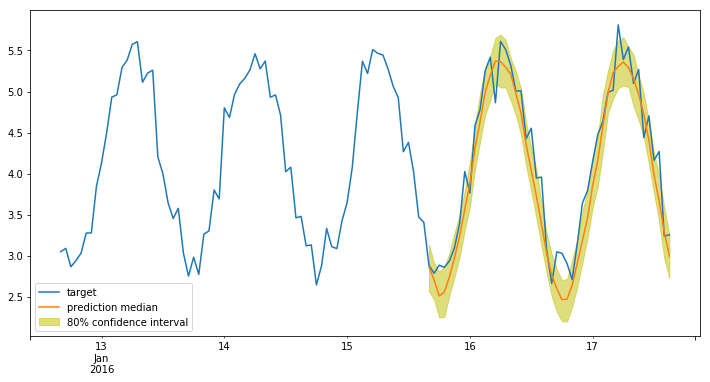

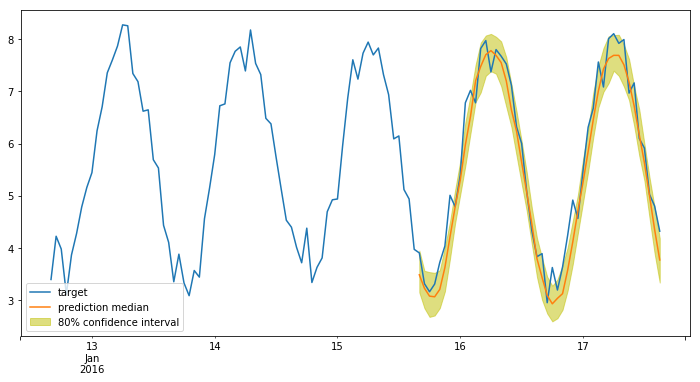

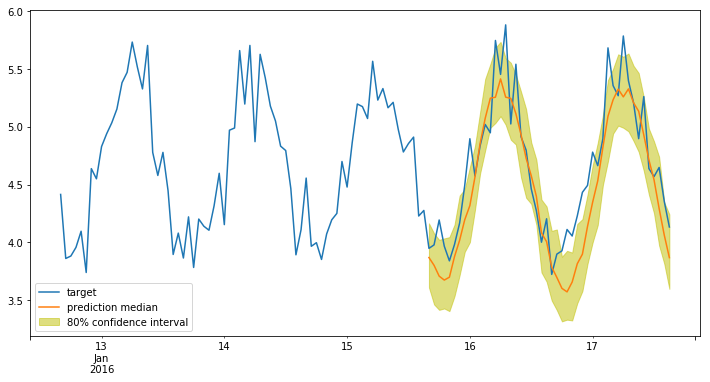

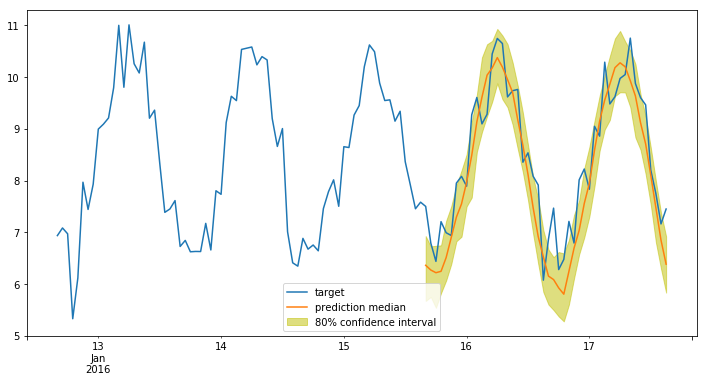

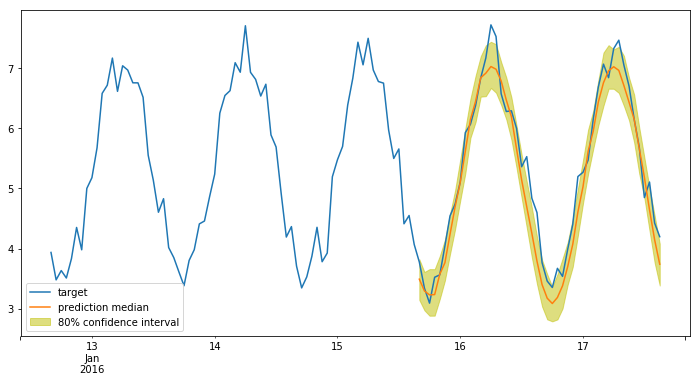

In [42]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Delete endpoint

In [55]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: Ferry-deepar-1-2019-03-27-17-21-33-127
